# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, desc, approx_count_distinct, col, to_date \
                                  , from_unixtime, to_date, year, dayofyear, dayofweek, \
                                  dayofmonth, datediff, countDistinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, RegexTokenizer, CountVectorizer, HashingTF, IDF, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession.builder \
        .master("local")    \
        .appName("Sparkify Project") \
        .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
mini_sparkify = 'mini_sparkify_event_data.json'
df = spark.read.json(mini_sparkify)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
(df.count(),len(df.columns))

(286500, 18)

In [6]:
def create_churn(df=df, cancelled='Cancelled'):
    flag_churn_event = udf(lambda x: 1 if x == "Cancelled" else 0, IntegerType())
    df = df.withColumn(cancelled, flag_churn_event("auth"))
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    df = df.withColumn("Churn", Fsum(cancelled).over(windowval))
    return df

df = create_churn()

In [7]:
pd_df = df.sample(withReplacement=True, fraction=0.5).toPandas()[:10000]

In [8]:
pd_df.shape

(10000, 20)

In [9]:
pd_df.isnull().sum().sort_values()

method              0
userId              0
userAgent           0
ts                  0
status              0
sessionId           0
registration        0
page                0
Cancelled           0
Churn               0
level               0
lastName            0
itemInSession       0
gender              0
firstName           0
auth                0
location            0
length           1638
song             1638
artist           1638
dtype: int64

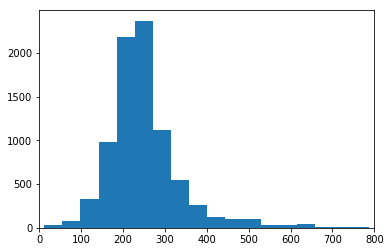

In [10]:
plt.hist(pd_df['length'].dropna(),bins=60);
plt.xlim(0,800);

(0, 8000)

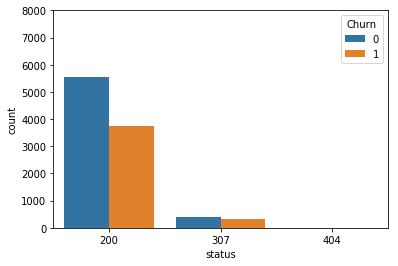

In [11]:
base_color = sns.color_palette()[0]
sns.countplot(data=pd_df, x='status', hue='Churn');
plt.ylim(0,8000)

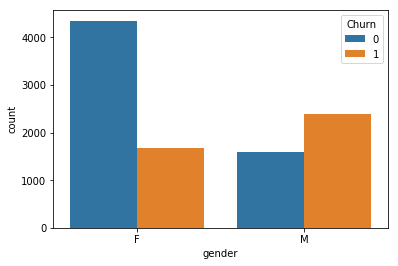

In [12]:
sns.countplot(data=pd_df, x='gender', hue='Churn');

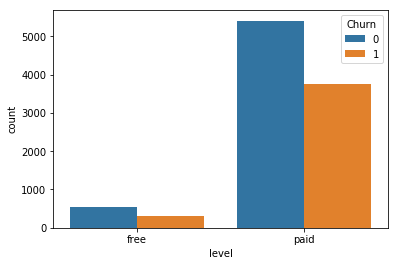

In [13]:
sns.countplot(data=pd_df, x='level', hue='Churn');

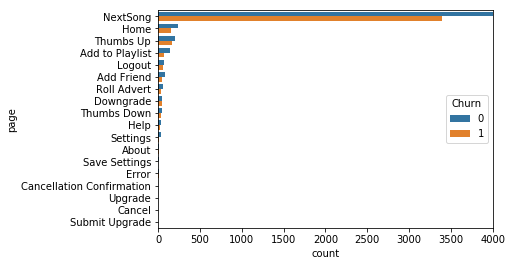

In [14]:
ordered_page = pd_df['page'].value_counts().index
sns.countplot(data=pd_df, y='page', order=ordered_page, hue='Churn');
plt.xlim(0,4000);

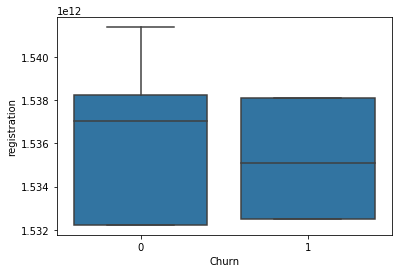

In [15]:
sns.boxplot(data=pd_df, x='Churn',color=base_color, y='registration');

In [16]:
pd_agg_df = pd_df.groupby('userId').agg({'length':'mean', 'song': pd.Series.nunique,\
                                         'Churn':'max'})

In [17]:
#Total number of sample users
pd_agg_df.shape[0]

13

In [18]:
#Churn number of smaple users
pd_agg_df[pd_agg_df.Churn == 1].shape[0]

5

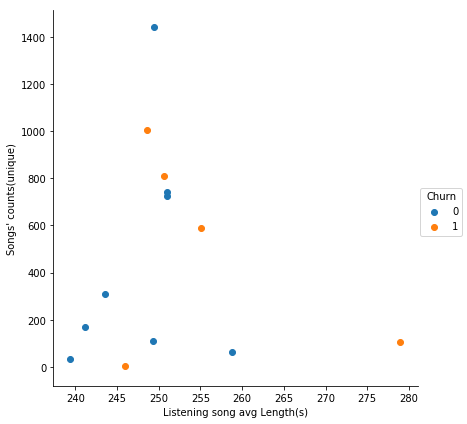

In [19]:
g = sns.FacetGrid(data=pd_agg_df,  hue='Churn', size=6);
g.map(plt.scatter, 'length', 'song');
plt.xlabel('Listening song avg Length(s)')
plt.ylabel("Songs' counts(unique)")
g.add_legend();

In [20]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- Churn: long (nullable = true)



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
df = df.withColumn('label', col('Churn'))

In [22]:
df = df.withColumn('registDays', datediff(to_date(from_unixtime(df['ts']/1000)), \
                                     to_date(from_unixtime(df['registration']/1000))))

In [23]:
levelTotal_df = df.groupby(['userId']).count().withColumnRenamed('count', 'levelTotal')

In [24]:
levelPaid_df = df[df.level=='paid'].groupby(['userId']).count().withColumnRenamed('count', 'levelPaid')

In [25]:
df = df.join(levelTotal_df, on='userId', how='inner')

In [26]:
df = df.join(levelPaid_df, on='userId', how='inner')

In [27]:
df = df.withColumn('paidRatio',df['levelPaid']/df['levelTotal'])

In [28]:
countDistinct_df = df.groupby(['userId']).agg(countDistinct('song').alias('countDistinctSongs'))

In [29]:
agg_df = df.groupby(['userId']).agg({'length':'mean', 'song':'count'})

In [30]:
df = df.join(countDistinct_df, on='userId', how='inner')

In [31]:
df = df.join(agg_df, on='userId', how='inner')

In [32]:
df = df.withColumnRenamed('count(song)', 'countSongs').withColumnRenamed('avg(length)', 'avgLength')

In [33]:
df = df.withColumn('replayRatio', df['countSongs']/df['countDistinctSongs'])

In [34]:
genderStringIndexer = StringIndexer(inputCol='gender', outputCol='genderIndexer', handleInvalid='skip')
#IndexerModel = genderStringIndexer.fit(df)
#df = IndexerModel.transform(df)

In [35]:
#userAgentStringIndexer = StringIndexer(inputCol='userAgent', outputCol='userAgentIndexer', handleInvalid='skip')

In [36]:
levelStringIndexer = StringIndexer(inputCol='level', outputCol='levelIndexer', handleInvalid='skip')

In [37]:
vectAssembler = VectorAssembler(inputCols=['genderIndexer', 'registDays', \
                                           'levelIndexer', 'paidRatio', 'avgLength', \
                                           'countSongs', 'countDistinctSongs', \
                                           'replayRatio'], outputCol='features')
#df = vectAssembler.transform(df)

In [38]:
rfc = RandomForestClassifier()

In [39]:
pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer, vectAssembler, rfc])

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [40]:
train, test = df.randomSplit([0.9, 0.1], seed=42)


In [41]:
paramGrid = ParamGridBuilder() \
            .addGrid(rfc.maxDepth, [2, 5, 10]) \
            .build()

In [42]:
crossvalid = CrossValidator(estimator=pipeline,
                            estimatorParamMaps=paramGrid,
                            evaluator=BinaryClassificationEvaluator(),
                            numFolds=2)

In [43]:
cvModel = crossvalid.fit(train)

In [44]:
prediction = cvModel.transform(test)

In [36]:
# selected = prediction.select("features", "label", "probability", "prediction")
# cnt = 0
# for row in selected.collect():
#     cnt += 1
#     if cnt >= 20:
#         break
#     print(row)

In [45]:
total = prediction.count()

26527

In [46]:
TP = prediction.filter((col("label") == 1 ) & (col("prediction") == 1)).count() / total

In [47]:
FP = prediction.filter((col("label") == 0 ) & (col("prediction") == 1)).count() / total

In [48]:
TN = prediction.filter((col("label") == 0 ) & (col("prediction") == 0)).count() / total

In [49]:
FN = prediction.filter((col("label") == 1 ) & (col("prediction") == 0)).count() / total

In [50]:
Accuracy = (TP + TN) / total

In [51]:
Accuracy

3.7383377904927814e-05

In [ ]:
#F1 = 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.